# Importing



In [37]:
#######################################################################
# Imports
#######################################################################
import logging
#This is going to help log information throughout our program. 
logging.basicConfig(
        level=logging.INFO, format="%(asctime)s %(levelname)s:%(message)s"
    )
logging.info("Loading libraries, takes aproximately 4 seconds.")


# Libraries that will be needed for everything to run
import cv2 as cv # used for handling the image aspect
import tarfile # used to untar the model downloaded
import shutil
import urllib.request # used to download
import os # file handling
import tensorflow as tf # used for detections model
import numpy as np # V1.2, added to fix adv noise saving.
import urllib
import urllib.request
logging.info('Done.')

2022-07-21 18:16:08,098 INFO:Loading libraries, takes aproximately 4 seconds.
2022-07-21 18:16:08,101 INFO:Done.


# Model



In [16]:

class Model():
  def __init__(self):

    self.download_model()
    self.model = self.initialize_model()

#######################################################################
#
#     Function that downloads models,
#     Input: Base Url, File name Outputs: None. 
#     Purpose:Downloads files
#
#######################################################################
  def Download(self,base_url, file_name):
    # checks if file exists

    if file_name not in os.listdir():
    
      #logs what is about to happen
      logging.info('Downloading ' + file_name) 
      
      #builds url
      url = base_url + file_name
      
      #retrieves what ever was in url by downloading it ...
      urllib.request.urlretrieve(url, file_name)
      logging.info('Download Complete')
      
      #This part checks it is is a tar file, a tar file is bunched up. 
      if file_name.find('.tar.gz') != -1:
        logging.info("Extracting " + file_name)
      
      # we are naming the the directory
      dir_name = file_name[0:-len('.tar.gz')]
      
      #check to see if path exist.
      if os.path.exists(dir_name):

      #if it does we want to erase the entire tree using shutil.rmtree
        shutil.rmtree(dir_name) 
      
      # Now we want to open the tarfile and extract all the information 
      tarfile.open(file_name, 'r:gz').extractall('./')
      
      #log extraction complete 
      logging.info("Extraction Complete")
    
    
    #if the file exist then we can  
    else:
      logging.info(file_name + ' already exists.')

#######################################################################
#
#   download_model  Inputs: None    Outputs: None     
#   
#######################################################################
  
  def download_model(self):
    #makes a call to download label.txt
    self.Download('https://raw.githubusercontent.com/nightrome/cocostuff/master/','labels.txt')
    #makes a call to download model
    self.Download('http://download.tensorflow.org/models/object_detection/', 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz')

#######################################################################

#######################################################################
# initialize_model    
# Inputs: None      
# Outputs: Returns a model that accepts one input. That model accepts tensored images... it then returns the detections  
#
#######################################################################  
  def initialize_model(self):
    #this is a preprocessing function need to help with the frozen graph
    def wrap_graph(graph_def, inputs, outputs, print_graph=False):
      wrapped = tf.compat.v1.wrap_function(lambda: tf.compat.v1.import_graph_def(graph_def, name=""), [])
      
      return wrapped.prune(
          tf.nest.map_structure(wrapped.graph.as_graph_element, inputs),
          tf.nest.map_structure(wrapped.graph.as_graph_element, outputs))
    
    
    # This is the format that we want outputs to follow  
    outputs = (
      'num_detections:0',
     'detection_classes:0',
     'detection_scores:0',
     'detection_boxes:0',
    )

    
    #We need to load a pre-trained model... This is done with the following. We care about frozen_inference_graph.pb because it holds a trained Tensor Flow graph that we can use for classification.
    frozen_graph = os.path.join('ssd_mobilenet_v1_coco_2018_01_28', 'frozen_inference_graph.pb')
    
    #This part of the code allows us to read the frozen graph (model). As you can see it saves and loads the file. the first part instantiates and the second part used parsefromstring in order to 
    #this part allows us to go through the file
    with tf.io.gfile.GFile(frozen_graph, "rb") as f:
      
      #This initializes a GraphDef which will be used to help with the loading part
      graph_def = tf.compat.v1.GraphDef()
      
      #This reads the files that we have
      loaded = graph_def.ParseFromString(f.read())

      #This used the frozen graph part and this makes the model. 
      model = wrap_graph(graph_def=graph_def, inputs=["image_tensor:0"], outputs=outputs)
      return model

#######################################################################

# Image Class


In [53]:


class Image():


  # We can modify priv_class in order to change things that we may want to add to the privacy scale.   
  priv_class=[12, 14, 30, 33, 46, 63, 65, 66, 70, 71, 72, 73, 74, 75, 76, 77, 85, 110, 133,31,69,3]
  
#######################################################################

  def get_image(self, image_path):
    #   Purpose: 
    #   Gets image from what is passed in 
    #   Input: 
    #   image_path or file name
    #   Output:
    #   image downloaded or image
    
    if image_path in os.listdir():
      image = cv.imread(image_path)
      image=cv.cvtColor(image,cv.COLOR_BGR2RGB)
    else:
      req = urllib.request.urlopen(image_path)
      arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
      image = cv.imdecode(arr, -1)
    
    return image


#                       VIPER Helpers
#######################################################################


  def priv_or_not(self,box_class):
    #   Purpose:  
    #   Used for a loop in blur to verify that our boxed detection is in our priv_class list 
    #   Input:  box_class (The detection class that our individual box is in)
    #   Output: Boolean           
    
    if box_class in self.priv_class:
      return True      
    else:
      return False

#######################################################################

  def object_blur(self, cv2_image, x1, x2, y1, y2, blurAmount):
    #Purpose:
    #Used for a loop in blur to Blur an object 
    #We call on this function repeatedly for every detection box in our detection.        

    #defines the outline of what we want to blur
    blurred_object = cv2_image[y1:y2,x1:x2]
    #This is the amount we want to blur 
    ksize = (blurAmount,blurAmount) 
    #We transform what we have in or outline into a blurred object  
    blurred_object = cv.blur(blurred_object, ksize, cv.BORDER_DEFAULT)    
    #We modify the section of the image to our blurred out version.
    cv2_image[y1:y2,x1:x2] = blurred_object
    #Returns the image
    self.modified= cv2_image
    self.image_saver()
    return self.modified


#######################################################################


  def image_saver(self):
    self.modified = cv.cvtColor(self.modified ,cv.COLOR_BGR2RGB)
    cv.imwrite('image.jpg',self.modified)


#######################################################################


  def box_to_pixels(self, box_bounds, cv2_image):
    #This function takes in box bound and an image, then it turn it into a coordinate
    #This allows us to border out what we want to pixalize. 
        
    y1 = int((box_bounds[0]*cv2_image.shape[0]).numpy())
    x1 = int((box_bounds[1]*cv2_image.shape[1]).numpy())
    y2 = int((box_bounds[2]*cv2_image.shape[0]).numpy())
    x2 = int((box_bounds[3]*cv2_image.shape[1]).numpy())
    
    return [x1,x2,y1,y2]


#######################################################################
#Heavy lifting, This function does the bluring using a for loop
#######################################################################


  def blur(self):
      
    for i in range(self.num_of_detections):
        
      single_box = self.detections[3][0][i]
      box_class = self.detections[1][0][i]
      
      if self.priv_or_not(box_class): 
        
        #VIPER_object_block(self.image, left, right, top, bottom, color)
        left, right, top, bottom = self.box_to_pixels(single_box, self.image)
        self.object_blur(self.image,left, right, top, bottom, 300)


#######################################################################
#######################################################################
  # block


  def object_block(self,image, x1, x2, y1, y2, color):
    thickness = -1
    image=cv.rectangle(image,(x1,y1),(x2,y2), color, thickness)

    return image




  def block(self):
    for i in range(self.num_of_detections):
      box = self.detections[3][0][i]
      box_class = self.detections[1][0][i]

      color = (0, 0, 0)
      if self.priv_or_not(box_class):
        left, right, top, bottom = self.box_to_pixels(box, self.image)
        self.modified=self.object_block(self.image, left, right, top, bottom, color)
    self.image_saver()




  def __init__(self, image_path, model):
    self.image= self.get_image(image_path)
    self.tensor = tf.convert_to_tensor([self.image], dtype=tf.uint8)
    self.model= model
    self.detections = self.model(self.tensor)
    
    self.num_of_detections= len([x for x in self.detections[3][0] if not ((x == self.detections[2][0][-1])[0])])
    self.detection_classes= [self.detections[1][0][x].numpy() for x in range(self.num_of_detections)]
    self.boxed_detections= self.detections[3][0]
    self.modified=None 
    #self.blur()
    #self.block()
    self.object_classes={}
    
    ###################################################################      
    for line in open("labels.txt"):
      line = line[:-1]
      key, value = line.split(': ')
      self.object_classes[int(key)] = value
    for i in self.detection_classes:
      object_class = int(i)
      object_bool = self.priv_or_not(object_class)
    ###################################################################



# Initialize Model


In [40]:
#######################################################################
#     We need a way to initialize the model and the name it something in order to pass it into the image class
#     Once we pass it into the image class we can then get the num of detections and so forth.
#######################################################################

model= Model().initialize_model()

2022-07-21 18:36:38,927 INFO:labels.txt already exists.
2022-07-21 18:36:38,931 INFO:ssd_mobilenet_v1_coco_2018_01_28.tar.gz already exists.


# Initialize Image Class... pass in image and model 


In [60]:
desk=Image("image.jpg",model)

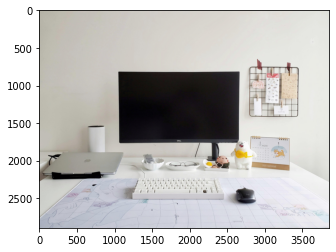

In [61]:
plt.imshow(desk.image)

In [42]:
import matplotlib.pyplot as plt

In [64]:
desk.block()

In [57]:
desk.modified

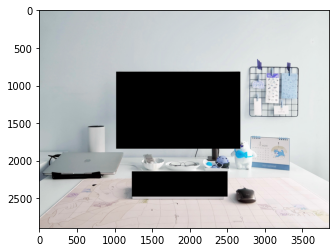

In [65]:
plt.imshow(desk.modified)

# Needs implementation




In [ ]:



# image changer
  def image_modifier(ImageType, modifier):
      if modifier.lower() == "blur" or modifier.lower()  == 'br':
        self.blur()
      #elif modifier.lower()  == "block" or modifier.lower()  == 'bk':
      #  VIPER_block(ImageType)
      #elif modifier.lower()  == "noise" or modifier.lower()  == 'ne':
      #  VIPER_advarserial_modifier(ImageType)
      #elif modifier.lower()  == "saliency" or modifier.lower()  == 'sy':
      #  VIPER_saliency_modifier(ImageType)
      #else:
      #  logging.info("No modifier ran.")

#######################################################################
#######################################################################


#######################################################################

#######################################################################
    
  def VIPER_object_block(cv2_image, x1, x2, y1, y2, color):
    thickness = -1
    cv.rectangle(cv2_image,(x1,y1),(x2,y2), color, thickness)

    return cv2_image


#######################################################################

#######################################################################
    
    def VIPER_block(self):
      for i in range(self.num_of_detections):
        box = self.detections[3][0][i]
        box_class = self.detections[1][0][i]
        color = (0, 0, 0)
        
        if priv_or_not(box_class):
          left, right, top, bottom = box_to_pixels(box, ImageType.image)
          VIPER_object_block(ImageType.image, left, right, top, bottom, color)

#######################################################################

#######################################################################

# saliency
    def VIPER_saliency_modifier(ImageType):
      saliency = cv.saliency.StaticSaliencySpectralResidual_create() #This intializes the saliency, and the below code creates a finer image which possibly could be used for instance segmentation

      (success, saliencyMap) = saliency.computeSaliency(ImageType.image) # this computes the map
      ImageType.image = (saliencyMap * 255).astype("uint8") # type casts and standardizes the image pixels 
  # threshMap = cv.threshold(saliencyMap, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1] #applies thereshold to get binary image from map 

# adverserial noise - FIX FIX FIX FIX
    def VIPER_advarserial_modifier(ImageType):
  # Helper function to preprocess the image so that it can be inputted in MobileNetV2
      def preprocess(image):
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, (224, 224))
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        image = image[None, ...]
        return image

      def create_adversarial_pattern(input_image, input_label, pretrained_model):
        loss_object = tf.keras.losses.CategoricalCrossentropy()
        with tf.GradientTape() as tape:
          tape.watch(input_image)
          prediction = pretrained_model(input_image)
          loss = loss_object(input_label, prediction)

        gradient = tape.gradient(loss, input_image) # Get the gradients of the loss w.r.t to the input image.
        signed_grad = tf.sign(gradient) # Get the sign of the gradients to create the perturbation

        return signed_grad

      pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet')
      pretrained_model.trainable = False

      adv_image = preprocess(ImageType.image)
      image_probs = pretrained_model.predict(adv_image)

  # Get the input label of the image.
      labrador_retriever_index = 1
      label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
      label = tf.reshape(label, (1, image_probs.shape[-1]))

      perturbations = create_adversarial_pattern(adv_image, label, pretrained_model)

      eps = 0.05
      adv_x = adv_image + eps*perturbations
      adv_x = tf.clip_by_value(adv_x, -1, 1)
      ImageType.image = adv_x[0]
      ImageType.image = np.clip(ImageType.image, 0, 1)
      ImageType.image = (ImageType.image * 255).astype(np.uint8)